In [154]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import pandas as pd
import re
import seaborn as sns
from sklearn.cluster import KMeans


# from sklearn.feature_extraction.text import TfidfVectorizer
# import sys
# import ssl
# from sklearn.preprocessing import StandardScaler
# import multiprocessing
# from time import time 
# import numpy as np

In [155]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Jul\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [156]:
newspaper_name = "NYT"

In [157]:
colnames = ['username', 'handle', 'postdate', 'text', 'reply_cnt', 'retweet_cnt']

In [158]:
df = pd.read_csv(f'Csv/{newspaper_name}_tweets_clear.csv', sep=';', names=colnames)

In [159]:
df

,username,handle,postdate,text,reply_cnt,retweet_cnt
0,The New York Times,@nytimes,2021-12-07T12:00:14.000Z,Volunteer Dies After a Sheep Charges at Her on...,41,71
1,The New York Times,@nytimes,2021-12-07T11:45:03.000Z,The Elusive Truth Behind the Attack on a Frenc...,12,40
2,The New York Times,@nytimes,2021-12-07T11:30:02.000Z,"Michael Steinhardt, Billionaire, Surrenders $7...",46,163
3,The New York Times,@nytimes,2021-12-07T11:15:04.000Z,Instagram Says Parental Controls Will Arrive i...,16,60
4,The New York Times,@nytimes,2021-12-07T11:00:18.000Z,Biden’s Supreme Court Commission Prepares to V...,24,40
...,...,...,...,...,...,...
278,The New York Times,@nytimes,2021-11-30T01:25:04.000Z,Elizabeth Holmes Says Former Boyfriend Abused ...,37,49
279,The New York Times Retweeted,@NYTScience,2021-11-30T01:05:00.000Z,The Math Equation That Tried to Stump the Inte...,121,90
280,The New York Times,@nytimes,2021-11-30T01:15:02.000Z,"What Is Cardiac Angiosarcoma? Virgil Abloh, th...",14,47
281,The New York Times,@nytimes,2021-11-30T01:00:04.000Z,"Who Is Parag Agrawal, Twitter’s New C.E.O.? A ...",28,95


In [160]:
def clean_sentences(df):
    headlines = []
    for sent in df['text']:
        # remove non-alphabetical characters
        text = re.sub('[^a-zA-Z]', ' ', str(sent))
        
        # tokenize sentence
        words = word_tokenize(text.lower())
        
        # remove stop words:
        new_words = [char for char in words if char.lower() not in stopwords.words('english')]
        new_words = ' '.join(new_words)

        headlines.append(new_words)
    return headlines

In [161]:
corpus = clean_sentences(df)
df["Cleaned_sentences"] = corpus

In [162]:
lemmatizer = WordNetLemmatizer()
pos=neg=0

pos_tagging = []

for news_header in df['Cleaned_sentences']:
    # Splitting sentence
    tokens = word_tokenize(news_header)
    # Part-of-speech tagging
    pos_tagging.append(nltk.pos_tag(tokens))

df['pos_tags'] = pos_tagging

# Clusterization by POS
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


# Returns list of pos-neg and objective score. But returns empty list if not present in senti wordnet.
def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    #Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    #Synset is a special kind of a simple interface that is present in NLTK to look up words in WordNet. 
    #Synset instances are the groupings of synonymous words that express the same concept. 
    #Some of the words have only one Synset and some have several.
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0
    
    ###################################################################################
senti_score = []

for pos_val in df['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  #positive score is stored at 2nd position
            neg = neg + score[2]  #negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0  
    
df['senti_score'] = senti_score

print(df.head)

<bound method NDFrame.head of                          username       handle                  postdate  \
0              The New York Times     @nytimes  2021-12-07T12:00:14.000Z   
1              The New York Times     @nytimes  2021-12-07T11:45:03.000Z   
2              The New York Times     @nytimes  2021-12-07T11:30:02.000Z   
3              The New York Times     @nytimes  2021-12-07T11:15:04.000Z   
4              The New York Times     @nytimes  2021-12-07T11:00:18.000Z   
..                            ...          ...                       ...   
278            The New York Times     @nytimes  2021-11-30T01:25:04.000Z   
279  The New York Times Retweeted  @NYTScience  2021-11-30T01:05:00.000Z   
280            The New York Times     @nytimes  2021-11-30T01:15:02.000Z   
281            The New York Times     @nytimes  2021-11-30T01:00:04.000Z   
282            The New York Times     @nytimes  2021-11-30T00:46:01.000Z   

                                                  text  r

In [164]:
df.iloc[:, [3, 8]]

,text,senti_score
0,Volunteer Dies After a Sheep Charges at Her on...,0.125
1,The Elusive Truth Behind the Attack on a Frenc...,0.375
2,"Michael Steinhardt, Billionaire, Surrenders $7...",-0.125
3,Instagram Says Parental Controls Will Arrive i...,-0.750
4,Biden’s Supreme Court Commission Prepares to V...,-0.250
...,...,...
278,Elizabeth Holmes Says Former Boyfriend Abused ...,-0.375
279,The Math Equation That Tried to Stump the Inte...,0.000
280,"What Is Cardiac Angiosarcoma? Virgil Abloh, th...",0.500
281,"Who Is Parag Agrawal, Twitter’s New C.E.O.? A ...",0.750


In [165]:
df["pos_tags"][3]

[('instagram', 'NN'),
 ('says', 'VBZ'),
 ('parental', 'JJ'),
 ('controls', 'NNS'),
 ('arrive', 'JJ'),
 ('march', 'NN'),
 ('adam', 'NN'),
 ('mosseri', 'NN'),
 ('head', 'NN'),
 ('company', 'NN'),
 ('expected', 'VBD'),
 ('face', 'NN'),
 ('questions', 'NNS'),
 ('lawmakers', 'NNS'),
 ('week', 'NN'),
 ('whether', 'IN'),
 ('social', 'JJ'),
 ('media', 'NNS'),
 ('harms', 'NNS'),
 ('children', 'NNS')]

In [166]:
overall=[]
for i in range(len(df)):
    if df['senti_score'][i]>= 0:
        overall.append('Positive')
    elif df['senti_score'][i]< 0:
        overall.append('Negative')
    else:
        overall.append('Neutral')
df['Overall Sentiment']=overall

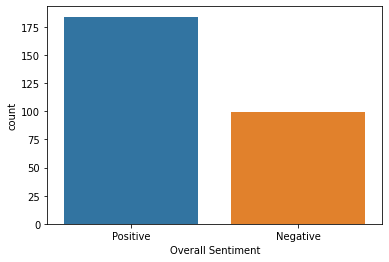

In [167]:
sns.countplot(df['Overall Sentiment'])

In [168]:
k_clusters = 2

model = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, max_iter=600, tol=0.000001, random_state=0)
model.fit(X_train_vc)

KMeans(max_iter=600, n_clusters=2, random_state=0, tol=1e-06)

In [169]:
clusters = model.predict(X_train_vc)

In [170]:
# Create a new column to display the predicted result
df["ClusterName"] = clusters
df.head(20)

,username,handle,postdate,text,reply_cnt,retweet_cnt,Cleaned_sentences,pos_tags,senti_score,Overall Sentiment,ClusterName
0,The New York Times,@nytimes,2021-12-07T12:00:14.000Z,Volunteer Dies After a Sheep Charges at Her on...,41,71,volunteer dies sheep charges therapy farm kim ...,"[(volunteer, NN), (dies, VBZ), (sheep, JJ), (c...",0.125,Positive,0
1,The New York Times,@nytimes,2021-12-07T11:45:03.000Z,The Elusive Truth Behind the Attack on a Frenc...,12,40,elusive truth behind attack french soccer star...,"[(elusive, JJ), (truth, NN), (behind, IN), (at...",0.375,Positive,0
2,The New York Times,@nytimes,2021-12-07T11:30:02.000Z,"Michael Steinhardt, Billionaire, Surrenders $7...",46,163,michael steinhardt billionaire surrenders mill...,"[(michael, NN), (steinhardt, NN), (billionaire...",-0.125,Negative,0
3,The New York Times,@nytimes,2021-12-07T11:15:04.000Z,Instagram Says Parental Controls Will Arrive i...,16,60,instagram says parental controls arrive march ...,"[(instagram, NN), (says, VBZ), (parental, JJ),...",-0.750,Negative,0
4,The New York Times,@nytimes,2021-12-07T11:00:18.000Z,Biden’s Supreme Court Commission Prepares to V...,24,40,biden supreme court commission prepares vote f...,"[(biden, JJ), (supreme, NN), (court, NN), (com...",-0.250,Negative,0
5,The New York Times,@nytimes,2021-12-07T10:45:08.000Z,"Ahead of Biden’s Democracy Summit, China Says:...",53,42,ahead biden democracy summit china says also d...,"[(ahead, RB), (biden, JJ), (democracy, NN), (s...",1.000,Positive,0
6,The New York Times,@nytimes,2021-12-07T10:30:05.000Z,Best Movies of 2021 Even when a film wasn’t gr...,10,31,best movies even film great filmgoing truly wo...,"[(best, JJS), (movies, NNS), (even, RB), (film...",3.000,Positive,0
7,The New York Times,@nytimes,2021-12-07T10:00:11.000Z,"Chanel, TikTok and the Beauty Advent Calendar ...",9,34,chanel tiktok beauty advent calendar controver...,"[(chanel, NNS), (tiktok, VBP), (beauty, NN), (...",1.125,Positive,0
8,The New York Times,@nytimes,2021-12-07T09:30:07.000Z,Trevor Noah Suggests Sending Marjorie Taylor G...,16,22,trevor noah suggests sending marjorie taylor g...,"[(trevor, NN), (noah, JJ), (suggests, VBZ), (s...",0.125,Positive,0
9,The New York Times,@nytimes,2021-12-07T09:00:12.000Z,Can Germany’s New Chancellor Revive the Left i...,21,49,germany new chancellor revive left europe olaf...,"[(germany, JJ), (new, JJ), (chancellor, NN), (...",0.875,Positive,0


In [171]:
len(df)

283

In [172]:
# 1 = Negative; 0 = Positive
cor_pos = 0; cor_neg = 0
for i in range(len(df)):
    if df["Overall Sentiment"].iloc[i] == "Positive" and df["ClusterName"].iloc[i] == 0:
        cor_pos +=1
    if df["Overall Sentiment"].iloc[i] == "Negative" and df["ClusterName"].iloc[i] == 1:
        cor_neg +=1
print(cor_pos, cor_neg)
print(cor_pos+cor_neg)

156 12
168


In [174]:
cor_neg = 0; cor_pos = 0
for i in range(len(df)):
    if df["ClusterName"].iloc[i] == 1:
        cor_neg +=1
    if df["ClusterName"].iloc[i] == 0:
        cor_pos +=1
        print(df["text"].iloc[i], "\n")
print(cor_neg, cor_pos)

Volunteer Dies After a Sheep Charges at Her on a Therapy Farm Kim Taylor, 73, went into cardiac arrest after being attacked while caring for livestock at a Massachusetts farm, the police said. 

The Elusive Truth Behind the Attack on a French Soccer Star The assault of a top women’s player made headlines, with masked men, a metal bar and a teammate arrested. But weeks later, new details suggest the original story might have been wrong. 

Michael Steinhardt, Billionaire, Surrenders $70 Million in Stolen Relics The hedge fund pioneer is barred for life from buying more antiquities. He turned over 180 stolen objects that had decorated his homes and office. 

Instagram Says Parental Controls Will Arrive in March Adam Mosseri, the head of the company, is expected to face questions from lawmakers this week about whether social media harms children. 

Biden’s Supreme Court Commission Prepares to Vote on Final Report A draft version of the document flagged deep disputes over court expansion wh

In [149]:
df.to_csv('CleanedData.csv')